In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import zipfile
import gdown
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image, ImageFile
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from torchvision import datasets, transforms
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
from google.colab import drive

# This will prompt you to authorize access to your Google Drive
drive.mount('/content/drive')
# Change the working directory to a folder in your Google Drive
os.chdir('/content/drive/MyDrive/Colab Notebooks/CombinedImages')

# Confirm the working directory has been changed
print("Current Working Directory: ", os.getcwd())

Mounted at /content/drive
Current Working Directory:  /content/drive/MyDrive/Colab Notebooks/CombinedImages


In [3]:
!ls

Data  Final_VGGNet.ipynb


## Load Dataset: Unable to Download Due to Restrictions/Error

# Load and Display Images (Loading dataset from Google Drive)




In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the size required by the model
    transforms.ToTensor(),           # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root='Data/', transform=transform)



# Define the proportions for train, val, and test
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # 15% for testing

print(train_size, val_size, test_size)



1492 319 321


In [5]:
from torch.utils.data import DataLoader, random_split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# Prepare Data for PyTorch

# Define VGGNet Model

In [6]:
# Define VGGNet model
class VGGNet(nn.Module):
    def __init__(self, num_classes=2):
        super(VGGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Train and Test the model

In [19]:
# Instantiate model, define loss and optimizer
model = VGGNet(num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training function
def train_model(model, traindataloader, testdataloader, criterion, optimizer, num_epochs=25):
    history = {'train loss': [], 'train accuracy': [], 'val loss': [], 'val accuracy': []}
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in traindataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(traindataloader.dataset)
        epoch_accuracy = 100 * correct / total
        history['train loss'].append(epoch_loss)
        history['train accuracy'].append(epoch_accuracy)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%')

        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in testdataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(testdataloader.dataset)
        val_epoch_accuracy = 100 * correct / total
        history['val loss'].append(val_epoch_loss)
        history['val accuracy'].append(val_epoch_accuracy)
        print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.2f}%')

    return model, history



# Move model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Train and test the model

model, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)




Epoch 1/10, Train Loss: 0.6736, Train Accuracy: 60.92%
Epoch 1/10, Val Loss: 0.6784, Val Accuracy: 59.25%
Epoch 2/10, Train Loss: 0.6706, Train Accuracy: 60.92%
Epoch 2/10, Val Loss: 0.6767, Val Accuracy: 59.25%
Epoch 3/10, Train Loss: 0.6698, Train Accuracy: 60.92%
Epoch 3/10, Val Loss: 0.6803, Val Accuracy: 59.25%
Epoch 4/10, Train Loss: 0.6696, Train Accuracy: 60.92%
Epoch 4/10, Val Loss: 0.6760, Val Accuracy: 59.25%
Epoch 5/10, Train Loss: 0.6702, Train Accuracy: 60.92%
Epoch 5/10, Val Loss: 0.6766, Val Accuracy: 59.25%
Epoch 6/10, Train Loss: 0.6703, Train Accuracy: 60.92%
Epoch 6/10, Val Loss: 0.6764, Val Accuracy: 59.25%
Epoch 7/10, Train Loss: 0.6702, Train Accuracy: 60.92%
Epoch 7/10, Val Loss: 0.6760, Val Accuracy: 59.25%
Epoch 8/10, Train Loss: 0.6714, Train Accuracy: 60.92%
Epoch 8/10, Val Loss: 0.6809, Val Accuracy: 59.25%
Epoch 9/10, Train Loss: 0.6706, Train Accuracy: 60.92%
Epoch 9/10, Val Loss: 0.6777, Val Accuracy: 59.25%
Epoch 10/10, Train Loss: 0.6699, Train Accurac

# Plot data

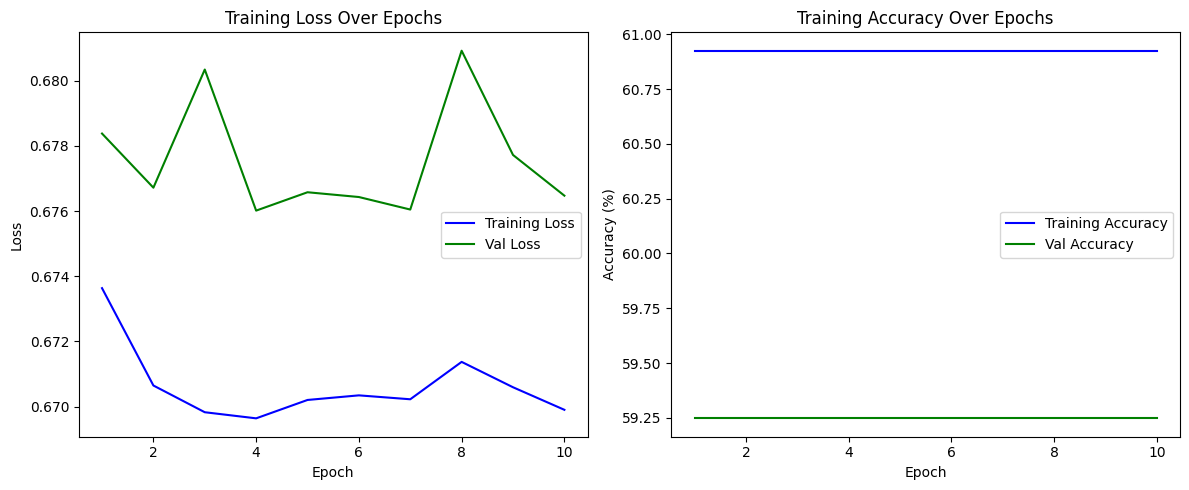

In [25]:
def plot_training_history(history):
    """Plot training loss and accuracy over epochs."""
    epochs = range(1, len(history['train loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val loss'], 'g-', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train accuracy'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val accuracy'], 'g-', label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function after training
plot_training_history(history)